# Cycling Performance Analysis from GPX File

This notebook analyzes cycling performance using GPS data from a GPX file. We will load, parse, and visualize the route, then calculate distance, elevation, speed, and time metrics.


## 1. Load GPX File

First, we'll load the contents of the GPX file (`Morning_Ride.gpx`).


In [1]:
# Load the GPX file
with open("Morning_Ride.gpx", "r") as file:
    gpx_data = file.read()

# Display the first 500 characters to confirm loading
print(gpx_data[:500])

<?xml version="1.0" encoding="UTF-8"?>
<gpx xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd http://www.garmin.com/xmlschemas/GpxExtensions/v3 http://www.garmin.com/xmlschemas/GpxExtensionsv3.xsd http://www.garmin.com/xmlschemas/TrackPointExtension/v1 http://www.garmin.com/xmlschemas/TrackPointExtensionv1.xsd" creator="StravaGPX" version="1.1" xmlns="http://www.topografix.com/GPX/1/1" xmlns:gpxtp


## 2. Parse GPX Data

We'll use the `gpxpy` library to parse the GPX data and extract track points. If not installed, install it first.


In [2]:
import gpxpy

gpx = gpxpy.parse(gpx_data)

# Extract all track points
track_points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            track_points.append(point)

print(f"Extracted {len(track_points)} track points.")
# Show the first 3 points as a sample
for pt in track_points[:3]:
    print(
        f"Lat: {pt.latitude}, Lon: {pt.longitude}, Ele: {pt.elevation}, Time: {pt.time}"
    )

Extracted 7918 track points.
Lat: 47.579221, Lon: -122.000199, Ele: 128.3, Time: 2024-12-01 18:05:07+00:00
Lat: 47.579163, Lon: -122.000361, Ele: 128.4, Time: 2024-12-01 18:05:08+00:00
Lat: 47.579192, Lon: -122.000404, Ele: 128.5, Time: 2024-12-01 18:05:09+00:00


## 3. Convert Track Points to DataFrame

We'll convert the track points to a pandas DataFrame for easier data manipulation and analysis.


In [3]:
import pandas as pd
from datetime import datetime
import xml.etree.ElementTree as ET

# Let's examine the extensions in more detail
for i, point in enumerate(track_points[:3]):
    print(f"Point {i} extensions type: {type(point.extensions)}")
    for ext in point.extensions:
        print(f"  Extension element: {ext}")
        print(f"  Extension tag: {ext.tag}")
        print(f"  Extension attrib: {ext.attrib}")
        # Check for children elements
        for child in list(ext):
            print(f"    Child: {child.tag} - {child.text}")

# Create a list of dictionaries with the data we want
data = []
for point in track_points:
    # Initialize heart_rate as None
    heart_rate = None

    # Try to extract heart rate from extensions
    if point.extensions:
        for ext in point.extensions:
            # Look for heart rate in children of the extension
            for child in list(ext):
                if "hr" in child.tag.lower():
                    try:
                        heart_rate = int(child.text)
                        break
                    except (ValueError, TypeError):
                        pass

    data.append(
        {
            "time": point.time,
            "latitude": point.latitude,
            "longitude": point.longitude,
            "elevation": point.elevation,
            "heart_rate": heart_rate,
        }
    )

# Convert to DataFrame
df = pd.DataFrame(data)

# Check if we have heart rate data
if df["heart_rate"].isnull().all():
    print("\nNo heart rate data found in the GPX file.")
else:
    print(
        f"\nHeart rate data found: {df['heart_rate'].notnull().sum()} points with heart rate information"
    )

# Display DataFrame info and first few rows
print("\nDataFrame Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Point 0 extensions type: <class 'list'>
  Extension element: <Element '{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension' at 0x0000029C958008B0>
  Extension tag: {http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension
  Extension attrib: {}
    Child: {http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr - 136
Point 1 extensions type: <class 'list'>
  Extension element: <Element '{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension' at 0x0000029C95800A40>
  Extension tag: {http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension
  Extension attrib: {}
    Child: {http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr - 136
Point 2 extensions type: <class 'list'>
  Extension element: <Element '{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension' at 0x0000029C958009A0>
  Extension tag: {http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension
  

## 4. Visualize Heart Rate Over Time

Let's visualize how heart rate changed during the ride to analyze effort levels.


C:\Users\milively\AppData\Local\Temp\ipykernel_16772\1463364471.py:15: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df["time_num"] = mdates.date2num(df["time"].dt.to_pydatetime())


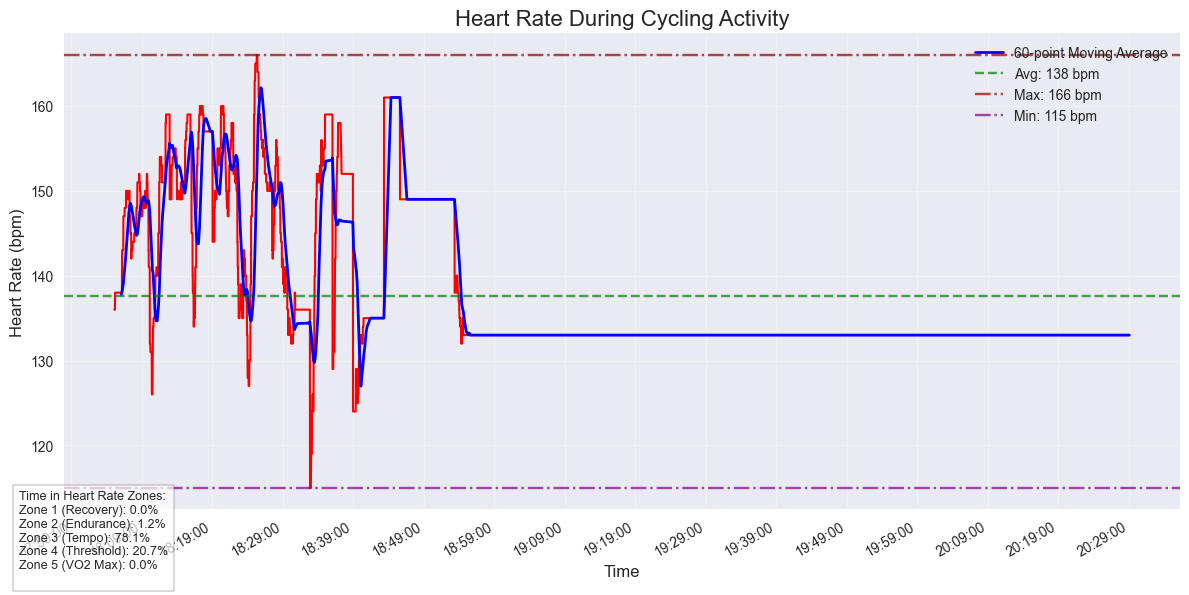

Heart Rate Statistics:
Average: 137.6 bpm
Maximum: 166 bpm
Minimum: 115 bpm
Standard Deviation: 8.5 bpm


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

# Set style for better visualization
plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

# Create figure and plot heart rate over time
plt.figure(figsize=(12, 6))

# Convert datetime to numbers for plotting
df["time_num"] = mdates.date2num(df["time"].dt.to_pydatetime())

# Plot heart rate data
plt.plot(df["time_num"], df["heart_rate"], color="red", linewidth=1.5)

# Add rolling average for smoother visualization
window = 60  # 1-minute rolling average
rolling_hr = df["heart_rate"].rolling(window=window).mean()
plt.plot(
    df["time_num"],
    rolling_hr,
    color="blue",
    linewidth=2,
    label=f"{window}-point Moving Average",
)

# Format x-axis with dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))  # every 10 minutes
plt.gcf().autofmt_xdate()  # Rotation

# Add min, max, and average lines
avg_hr = df["heart_rate"].mean()
max_hr = df["heart_rate"].max()
min_hr = df["heart_rate"].min()

plt.axhline(
    y=avg_hr, color="green", linestyle="--", alpha=0.7, label=f"Avg: {avg_hr:.0f} bpm"
)
plt.axhline(
    y=max_hr, color="darkred", linestyle="-.", alpha=0.7, label=f"Max: {max_hr:.0f} bpm"
)
plt.axhline(
    y=min_hr, color="purple", linestyle="-.", alpha=0.7, label=f"Min: {min_hr:.0f} bpm"
)

# Calculate and display heart rate zones
hr_zones = {
    "Zone 1 (Recovery)": (0, 0.6),  # 0-60% of max HR
    "Zone 2 (Endurance)": (0.6, 0.7),  # 60-70% of max HR
    "Zone 3 (Tempo)": (0.7, 0.8),  # 70-80% of max HR
    "Zone 4 (Threshold)": (0.8, 0.9),  # 80-90% of max HR
    "Zone 5 (VO2 Max)": (0.9, 1.0),  # 90-100% of max HR
}

# Assuming a simple max HR calculation (220 - age). Using 35 as example age, adjust as needed.
estimated_max_hr = 220 - 35
time_in_zones = {}

for zone_name, (lower_pct, upper_pct) in hr_zones.items():
    lower_bound = lower_pct * estimated_max_hr
    upper_bound = upper_pct * estimated_max_hr
    in_zone = (df["heart_rate"] >= lower_bound) & (df["heart_rate"] < upper_bound)
    time_in_zones[zone_name] = in_zone.sum()

# Calculate percentages
total_points = len(df)
zone_percentages = {
    zone: (count / total_points) * 100 for zone, count in time_in_zones.items()
}

# Format plot
plt.title("Heart Rate During Cycling Activity", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Heart Rate (bpm)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")

# Add text box with zone percentages
zone_text = "Time in Heart Rate Zones:\n"
for zone, percentage in zone_percentages.items():
    zone_text += f"{zone}: {percentage:.1f}%\n"

plt.figtext(0.02, 0.02, zone_text, bbox=dict(facecolor="white", alpha=0.7), fontsize=9)

# Show the plot
plt.tight_layout()
plt.show()

# Print heart rate statistics summary
print(f"Heart Rate Statistics:")
print(f"Average: {avg_hr:.1f} bpm")
print(f"Maximum: {max_hr} bpm")
print(f"Minimum: {min_hr} bpm")
print(f"Standard Deviation: {df['heart_rate'].std():.1f} bpm")

## 5. Map Visualization of the Cycling Route

Let's visualize the route on an interactive map with elevation and heart rate data.


In [5]:
import folium
from folium.plugins import HeatMap
import numpy as np

# Calculate the center of the route for the map start position
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

# Create the map
route_map = folium.Map(
    location=[center_lat, center_lon], zoom_start=13, tiles="openstreetmap"
)

# Create a feature group for the route
route = folium.FeatureGroup(name="Cycling Route")

# Add the cycling route as a polyline
points = list(zip(df["latitude"], df["longitude"]))
folium.PolyLine(
    points, color="blue", weight=3, opacity=0.8, tooltip="Cycling Route"
).add_to(route)

# Add markers for start and end points
start_point = df.iloc[0]
end_point = df.iloc[-1]

folium.Marker(
    location=[start_point["latitude"], start_point["longitude"]],
    popup="Start Point",
    icon=folium.Icon(color="green", icon="play", prefix="fa"),
).add_to(route)

folium.Marker(
    location=[end_point["latitude"], end_point["longitude"]],
    popup="End Point",
    icon=folium.Icon(color="red", icon="stop", prefix="fa"),
).add_to(route)

# Add route to map
route.add_to(route_map)

# Create a feature group for heart rate visualization
heart_rate_layer = folium.FeatureGroup(name="Heart Rate (click to toggle)")

# Normalize heart rate for color coding
hr_min = df["heart_rate"].min()
hr_max = df["heart_rate"].max()

# Sample every N points to avoid overcrowding the map
sample_rate = max(1, len(df) // 200)  # Aim for around 200 points max

# Add circles for heart rate at each point, colored by intensity
for i in range(0, len(df), sample_rate):
    point = df.iloc[i]
    hr = point["heart_rate"]

    # Normalize heart rate (0-1 scale)
    hr_normalized = (hr - hr_min) / (hr_max - hr_min)

    # Generate color from blue (low) to red (high)
    color = (
        f"#{int(255 * (1 - hr_normalized)):02x}{0:02x}{int(255 * hr_normalized):02x}"
    )

    # Create popup content with relevant information
    popup_content = f"""
    <b>Time:</b> {point["time"]}<br>
    <b>Heart Rate:</b> {hr} bpm<br>
    <b>Elevation:</b> {point["elevation"]:.1f} m
    """

    # Add circle
    folium.CircleMarker(
        location=[point["latitude"], point["longitude"]],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300),
    ).add_to(heart_rate_layer)

# Add heart rate layer to map
heart_rate_layer.add_to(route_map)

# Add elevation data as a heatmap
elevation_layer = folium.FeatureGroup(name="Elevation Heatmap (click to toggle)")

# Create elevation heat data
elevation_data = []
for i in range(0, len(df), sample_rate):
    point = df.iloc[i]
    # Normalize elevation for better visualization
    elevation_normalized = (point["elevation"] - df["elevation"].min()) / (
        df["elevation"].max() - df["elevation"].min()
    )
    elevation_data.append(
        [point["latitude"], point["longitude"], elevation_normalized * 0.5]
    )  # Scale down intensity

# Add heatmap if we have data
if elevation_data:
    HeatMap(
        elevation_data, radius=12, gradient={0.2: "blue", 0.5: "lime", 0.8: "red"}
    ).add_to(elevation_layer)

# Add elevation layer to map
elevation_layer.add_to(route_map)

# Add layer control to toggle between layers
folium.LayerControl().add_to(route_map)

# Display the map
route_map

## 6. Speed and Pace Analysis

Let's calculate and analyze speed metrics from the cycling activity, including average speed, speed distribution, and speed over time.


In [6]:
# Install required packages
%pip install scipy haversine

Note: you may need to restart the kernel to use updated packages.


C:\Users\milively\AppData\Local\Temp\ipykernel_16772\4076092017.py:63: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_speed["time_num"] = mdates.date2num(df_speed["time"].dt.to_pydatetime())


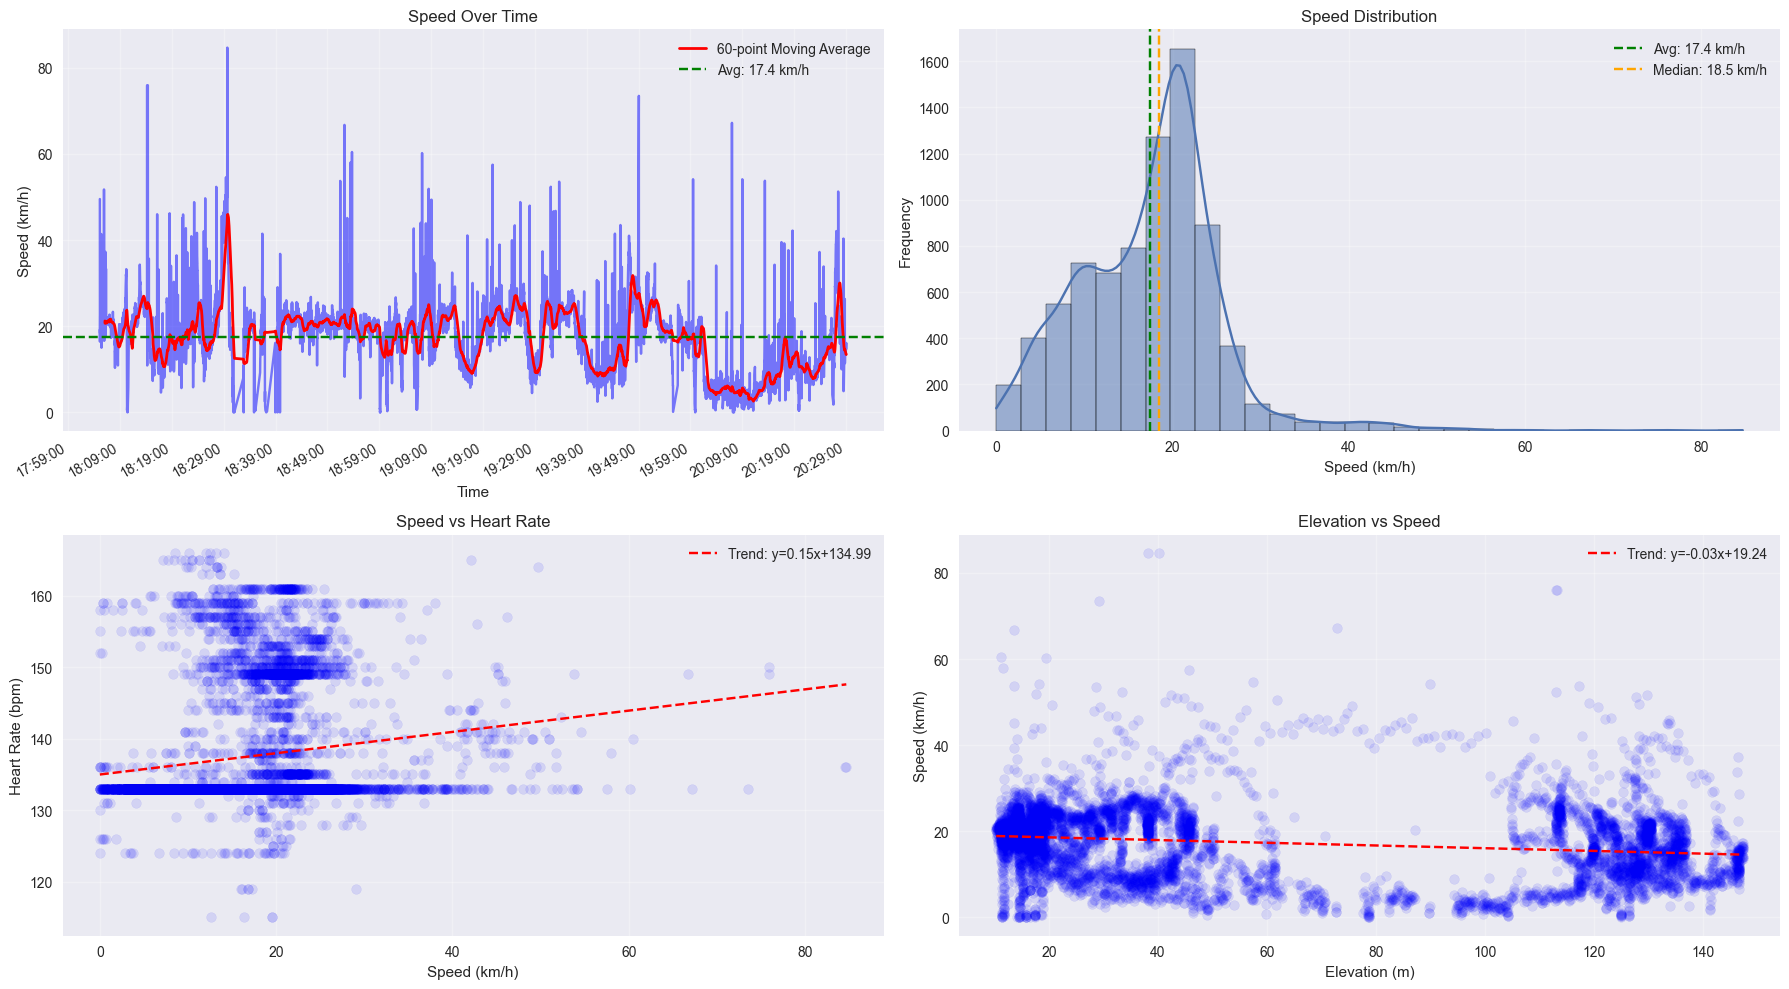

Speed Statistics:
Total Distance: 39.81 km
Total Time: 2h 23m
Moving Time: 2h 15m
Average Speed: 17.42 km/h
Average Moving Speed: 17.62 km/h
Maximum Speed: 84.68 km/h
Median Speed: 18.46 km/h
Speed Standard Deviation: 8.02 km/h


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import haversine as hs
import matplotlib.dates as mdates

# Calculate distance between consecutive points and time differences
df["next_lat"] = df["latitude"].shift(-1)
df["next_lon"] = df["longitude"].shift(-1)
df["next_time"] = df["time"].shift(-1)

# Remove the last row which has NaN for next values
df_calc = df.dropna(subset=["next_lat", "next_lon", "next_time"]).copy()

# Calculate distance in meters using Haversine formula
distances = []
for i, row in df_calc.iterrows():
    point1 = (row["latitude"], row["longitude"])
    point2 = (row["next_lat"], row["next_lon"])
    # Calculate distance in kilometers, then convert to meters
    distance = hs.haversine(point1, point2, unit=hs.Unit.KILOMETERS) * 1000
    distances.append(distance)

df_calc.loc[:, "distance_m"] = distances

# Calculate time differences in seconds
df_calc.loc[:, "time_diff_s"] = (
    df_calc["next_time"] - df_calc["time"]
).dt.total_seconds()

# Calculate speed in m/s and km/h
df_calc.loc[:, "speed_mps"] = df_calc["distance_m"] / df_calc["time_diff_s"]
df_calc.loc[:, "speed_kph"] = df_calc["speed_mps"] * 3.6  # Convert m/s to km/h

# Remove unrealistic speeds (e.g., GPS errors)
# Filter out speeds over 100 km/h which are likely GPS errors for cycling
df_speed = df_calc[df_calc["speed_kph"] < 100].copy()

# Calculate statistics
avg_speed = df_speed["speed_kph"].mean()
max_speed = df_speed["speed_kph"].max()
median_speed = df_speed["speed_kph"].median()
speed_std = df_speed["speed_kph"].std()

# Calculate total distance
total_distance_km = df_speed["distance_m"].sum() / 1000

# Calculate total time
total_time_seconds = df_speed["time_diff_s"].sum()
total_time_hours = total_time_seconds / 3600

# Calculate moving time (excluding very low speeds, e.g., < 2 km/h)
moving_data = df_speed[df_speed["speed_kph"] > 2]
moving_time_seconds = moving_data["time_diff_s"].sum()
moving_time_hours = moving_time_seconds / 3600
moving_avg_speed = total_distance_km / moving_time_hours if moving_time_hours > 0 else 0

# Create visualizations
plt.figure(figsize=(18, 10))

# 1. Speed over time - use time_num for plotting time
df_speed["time_num"] = mdates.date2num(df_speed["time"].dt.to_pydatetime())
plt.subplot(2, 2, 1)
plt.plot(df_speed["time_num"], df_speed["speed_kph"], color="blue", alpha=0.5)

# Add moving average
window = 60  # 1-minute window
rolling_speed = df_speed["speed_kph"].rolling(window=window).mean()
plt.plot(
    df_speed["time_num"],
    rolling_speed,
    color="red",
    linewidth=2,
    label=f"{window}-point Moving Average",
)
plt.axhline(
    y=avg_speed, color="green", linestyle="--", label=f"Avg: {avg_speed:.1f} km/h"
)
plt.title("Speed Over Time")
plt.xlabel("Time")
plt.ylabel("Speed (km/h)")
plt.grid(True, alpha=0.3)
# Format x-axis with dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))  # every 10 minutes
plt.gcf().autofmt_xdate()  # Rotation
plt.legend()

# 2. Speed distribution
plt.subplot(2, 2, 2)
sns.histplot(df_speed["speed_kph"], kde=True, bins=30)
plt.title("Speed Distribution")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.axvline(
    x=avg_speed, color="green", linestyle="--", label=f"Avg: {avg_speed:.1f} km/h"
)
plt.axvline(
    x=median_speed,
    color="orange",
    linestyle="--",
    label=f"Median: {median_speed:.1f} km/h",
)
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Speed vs Heart Rate scatter plot
plt.subplot(2, 2, 3)
plt.scatter(df_speed["speed_kph"], df_speed["heart_rate"], alpha=0.1, color="blue")
plt.title("Speed vs Heart Rate")
plt.xlabel("Speed (km/h)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True, alpha=0.3)

# Add trendline
z = np.polyfit(df_speed["speed_kph"], df_speed["heart_rate"], 1)
p = np.poly1d(z)
plt.plot(
    np.sort(df_speed["speed_kph"]),
    p(np.sort(df_speed["speed_kph"])),
    color="red",
    linestyle="--",
    label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}",
)
plt.legend()

# 4. Speed vs Elevation scatter plot
plt.subplot(2, 2, 4)
plt.scatter(df_speed["elevation"], df_speed["speed_kph"], alpha=0.1, color="blue")
plt.title("Elevation vs Speed")
plt.xlabel("Elevation (m)")
plt.ylabel("Speed (km/h)")
plt.grid(True, alpha=0.3)

# Add trendline
z = np.polyfit(df_speed["elevation"], df_speed["speed_kph"], 1)
p = np.poly1d(z)
plt.plot(
    np.sort(df_speed["elevation"]),
    p(np.sort(df_speed["elevation"])),
    color="red",
    linestyle="--",
    label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}",
)
plt.legend()

plt.tight_layout()
plt.show()

# Print speed statistics
print(f"Speed Statistics:")
print(f"Total Distance: {total_distance_km:.2f} km")
print(f"Total Time: {int(total_time_hours)}h {int((total_time_hours % 1) * 60):02d}m")
print(
    f"Moving Time: {int(moving_time_hours)}h {int((moving_time_hours % 1) * 60):02d}m"
)
print(f"Average Speed: {avg_speed:.2f} km/h")
print(f"Average Moving Speed: {moving_avg_speed:.2f} km/h")
print(f"Maximum Speed: {max_speed:.2f} km/h")
print(f"Median Speed: {median_speed:.2f} km/h")
print(f"Speed Standard Deviation: {speed_std:.2f} km/h")

## 7. Elevation and Climb Analysis

Let's analyze the elevation profile of the ride, calculate total climbing, and visualize the elevation changes throughout the route.


C:\Users\milively\AppData\Local\Temp\ipykernel_16772\2830988028.py:124: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  time_num = mdates.date2num(df_sorted["time"].dt.to_pydatetime())


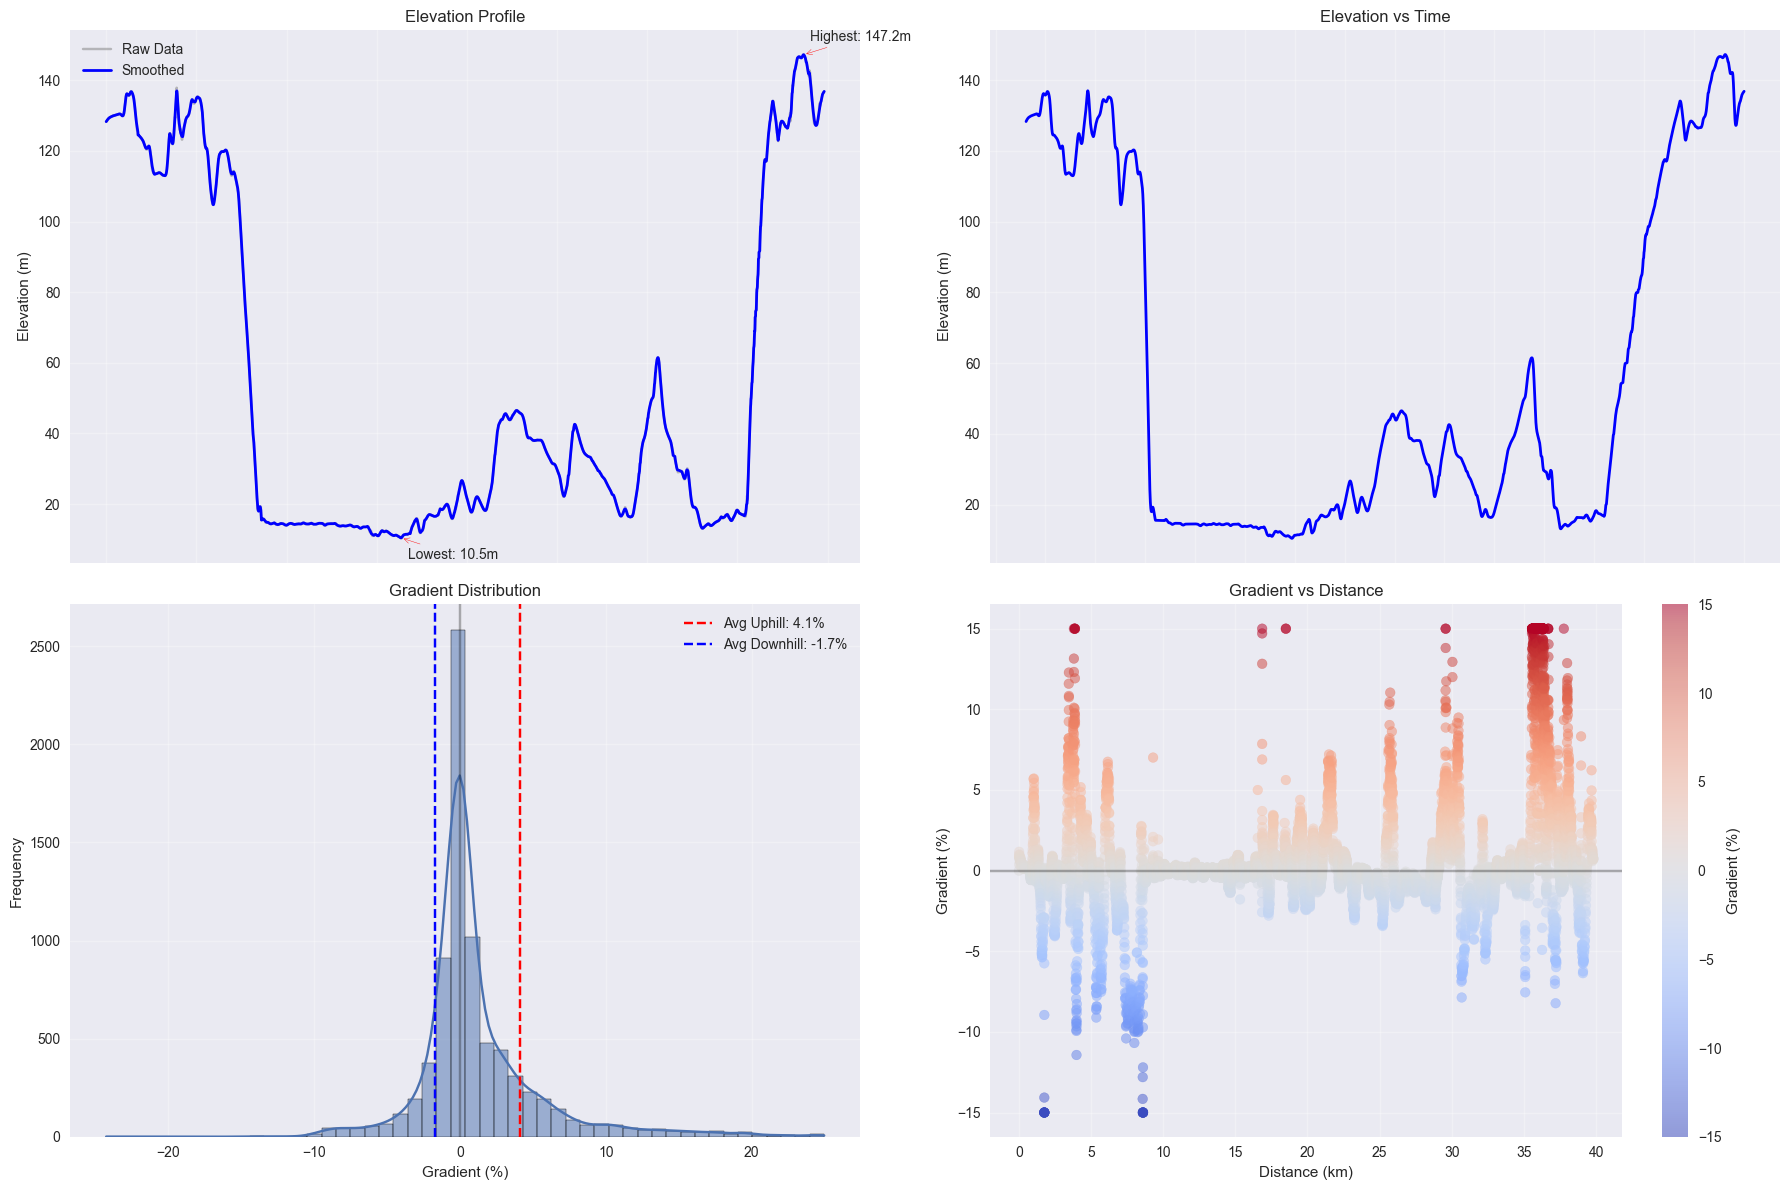

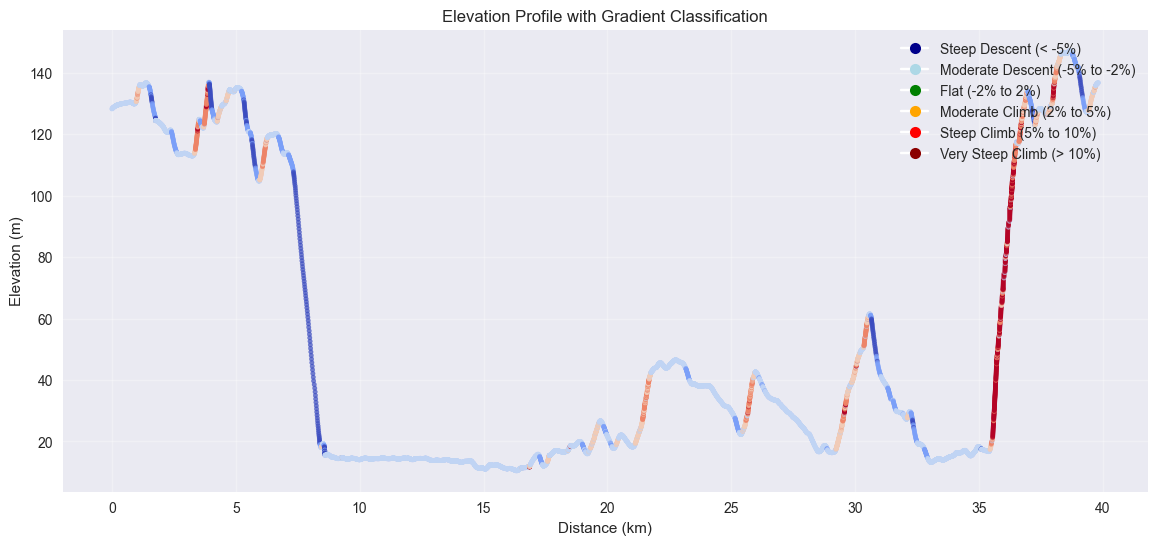

Elevation Statistics:
Minimum Elevation: 10.5 m
Maximum Elevation: 147.2 m
Elevation Range: 136.8 m
Total Climbing: 365.5 m
Total Descent: 357.0 m
Maximum Uphill Gradient: 25.0%
Maximum Downhill Gradient: -24.3%
Average Uphill Gradient: 4.1%
Average Downhill Gradient: -1.7%


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from scipy.signal import savgol_filter

# Calculate distance along route (cumulative)
# First, let's ensure our dataframe is sorted by time
df_sorted = df.sort_values("time").copy()

# Reset index for easier calculations
df_sorted.reset_index(drop=True, inplace=True)

# Calculate incremental distances between consecutive points
distances = [0]  # First point has zero distance

for i in range(1, len(df_sorted)):
    point1 = (df_sorted.loc[i - 1, "latitude"], df_sorted.loc[i - 1, "longitude"])
    point2 = (df_sorted.loc[i, "latitude"], df_sorted.loc[i, "longitude"])
    # Calculate distance in kilometers
    distance = hs.haversine(point1, point2, unit=hs.Unit.KILOMETERS)
    distances.append(distance)

# Add distances to dataframe
df_sorted["incremental_dist_km"] = distances

# Calculate cumulative distance
df_sorted["cumulative_dist_km"] = df_sorted["incremental_dist_km"].cumsum()

# Apply smoothing to elevation data to reduce GPS noise
# Window size must be odd and less than data length
window_size = min(51, len(df_sorted) - (1 if len(df_sorted) % 2 == 0 else 0))
if window_size < 3:
    window_size = 3

# Apply Savitzky-Golay filter for smoothing elevation data
try:
    df_sorted["elevation_smooth"] = savgol_filter(
        df_sorted["elevation"], window_size, 3
    )
except:
    # If smoothing fails, use the original elevation data
    df_sorted["elevation_smooth"] = df_sorted["elevation"]

# Calculate elevation differences between consecutive points
elev_diffs = [0]  # First point has no elevation difference
for i in range(1, len(df_sorted)):
    elev_diff = (
        df_sorted.loc[i, "elevation_smooth"] - df_sorted.loc[i - 1, "elevation_smooth"]
    )
    elev_diffs.append(elev_diff)

df_sorted["elev_diff"] = elev_diffs

# Calculate total elevation gain and loss
total_gain = df_sorted[df_sorted["elev_diff"] > 0]["elev_diff"].sum()
total_loss = abs(df_sorted[df_sorted["elev_diff"] < 0]["elev_diff"].sum())

# Calculate max and average gradient
df_sorted["gradient"] = (
    df_sorted["elev_diff"] / (df_sorted["incremental_dist_km"] * 1000) * 100
)
df_sorted.loc[df_sorted["incremental_dist_km"] == 0, "gradient"] = (
    0  # Avoid division by zero
)

# Filter out unreasonable gradient values (e.g., GPS errors)
reasonable_gradients = df_sorted[abs(df_sorted["gradient"]) < 25]["gradient"]
max_gradient_up = reasonable_gradients.max()
max_gradient_down = reasonable_gradients.min()
avg_gradient_up = df_sorted[df_sorted["gradient"] > 0]["gradient"].mean()
avg_gradient_down = df_sorted[df_sorted["gradient"] < 0]["gradient"].mean()

# Create visualizations
plt.figure(figsize=(18, 12))

# 1. Elevation Profile
plt.subplot(2, 2, 1)
plt.plot(
    df_sorted["cumulative_dist_km"],
    df_sorted["elevation"],
    color="gray",
    alpha=0.5,
    label="Raw Data",
)
plt.plot(
    df_sorted["cumulative_dist_km"],
    df_sorted["elevation_smooth"],
    color="blue",
    linewidth=2,
    label="Smoothed",
)
plt.title("Elevation Profile")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations for highest and lowest points
max_elev_idx = df_sorted["elevation_smooth"].idxmax()
min_elev_idx = df_sorted["elevation_smooth"].idxmin()
max_elev = df_sorted.loc[max_elev_idx, "elevation_smooth"]
min_elev = df_sorted.loc[min_elev_idx, "elevation_smooth"]
max_dist = df_sorted.loc[max_elev_idx, "cumulative_dist_km"]
min_dist = df_sorted.loc[min_elev_idx, "cumulative_dist_km"]

plt.annotate(
    f"Highest: {max_elev:.1f}m",
    xy=(max_dist, max_elev),
    xytext=(5, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="red"),
)
plt.annotate(
    f"Lowest: {min_elev:.1f}m",
    xy=(min_dist, min_elev),
    xytext=(5, -15),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="red"),
)

# 2. Elevation vs Time
plt.subplot(2, 2, 2)
time_num = mdates.date2num(df_sorted["time"].dt.to_pydatetime())
plt.plot(time_num, df_sorted["elevation_smooth"], color="blue", linewidth=2)
plt.title("Elevation vs Time")
plt.xlabel("Time")
plt.ylabel("Elevation (m)")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.gcf().autofmt_xdate()

# 3. Gradient Distribution
plt.subplot(2, 2, 3)
# Filter out extreme values for visualization
gradient_for_plot = df_sorted[abs(df_sorted["gradient"]) < 25]["gradient"]
sns.histplot(gradient_for_plot, kde=True, bins=50)
plt.title("Gradient Distribution")
plt.xlabel("Gradient (%)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
plt.axvline(
    x=avg_gradient_up,
    color="red",
    linestyle="--",
    label=f"Avg Uphill: {avg_gradient_up:.1f}%",
)
plt.axvline(
    x=avg_gradient_down,
    color="blue",
    linestyle="--",
    label=f"Avg Downhill: {avg_gradient_down:.1f}%",
)
plt.legend()

# 4. Gradient vs Distance (Color-coded)
plt.subplot(2, 2, 4)
plt.scatter(
    df_sorted["cumulative_dist_km"],
    df_sorted["gradient"].clip(-15, 15),  # Clip extreme values for better visualization
    c=df_sorted["gradient"].clip(-15, 15),
    cmap="coolwarm",
    alpha=0.5,
)
plt.colorbar(label="Gradient (%)")
plt.title("Gradient vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Gradient (%)")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)

plt.tight_layout()
plt.show()

# Create a separate plot for climbing profile with colored segments
plt.figure(figsize=(14, 6))
gradient_colors = np.zeros(len(df_sorted))

# Create color codes for different gradient ranges
# -5% or steeper (fast descent): dark blue
# -5% to -2% (moderate descent): light blue
# -2% to 2% (flat): green
# 2% to 5% (moderate climb): orange
# 5% to 10% (steep climb): red
# 10%+ (very steep climb): dark red

for i, gradient in enumerate(df_sorted["gradient"]):
    if gradient < -5:
        gradient_colors[i] = -2  # Dark blue
    elif -5 <= gradient < -2:
        gradient_colors[i] = -1  # Light blue
    elif -2 <= gradient < 2:
        gradient_colors[i] = 0  # Green
    elif 2 <= gradient < 5:
        gradient_colors[i] = 1  # Orange
    elif 5 <= gradient < 10:
        gradient_colors[i] = 2  # Red
    else:
        gradient_colors[i] = 3  # Dark red

scatter = plt.scatter(
    df_sorted["cumulative_dist_km"],
    df_sorted["elevation_smooth"],
    c=gradient_colors,
    cmap="coolwarm",
    s=10,
    alpha=0.7,
)

# Create custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="darkblue",
        markersize=8,
        label="Steep Descent (< -5%)",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="lightblue",
        markersize=8,
        label="Moderate Descent (-5% to -2%)",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="green",
        markersize=8,
        label="Flat (-2% to 2%)",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="orange",
        markersize=8,
        label="Moderate Climb (2% to 5%)",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=8,
        label="Steep Climb (5% to 10%)",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="darkred",
        markersize=8,
        label="Very Steep Climb (> 10%)",
    ),
]
plt.legend(handles=legend_elements, loc="upper right")

plt.title("Elevation Profile with Gradient Classification")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.grid(True, alpha=0.3)
plt.show()

# Print elevation statistics
print(f"Elevation Statistics:")
print(f"Minimum Elevation: {df_sorted['elevation_smooth'].min():.1f} m")
print(f"Maximum Elevation: {df_sorted['elevation_smooth'].max():.1f} m")
print(
    f"Elevation Range: {df_sorted['elevation_smooth'].max() - df_sorted['elevation_smooth'].min():.1f} m"
)
print(f"Total Climbing: {total_gain:.1f} m")
print(f"Total Descent: {total_loss:.1f} m")
print(f"Maximum Uphill Gradient: {max_gradient_up:.1f}%")
print(f"Maximum Downhill Gradient: {max_gradient_down:.1f}%")
print(f"Average Uphill Gradient: {avg_gradient_up:.1f}%")
print(f"Average Downhill Gradient: {avg_gradient_down:.1f}%")

## 8. Performance Summary

Let's create a comprehensive summary of the ride performance, combining speed, heart rate, elevation, and other key metrics.


C:\Users\milively\AppData\Local\Temp\ipykernel_16772\1605416561.py:66: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  time_num = mdates.date2num(np.array(df["time"].dt.to_pydatetime()))
C:\Users\milively\AppData\Local\Temp\ipykernel_16772\1605416561.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  mdates.date2num(np.array(speed_df["time"].dt.to_pydatetime())),


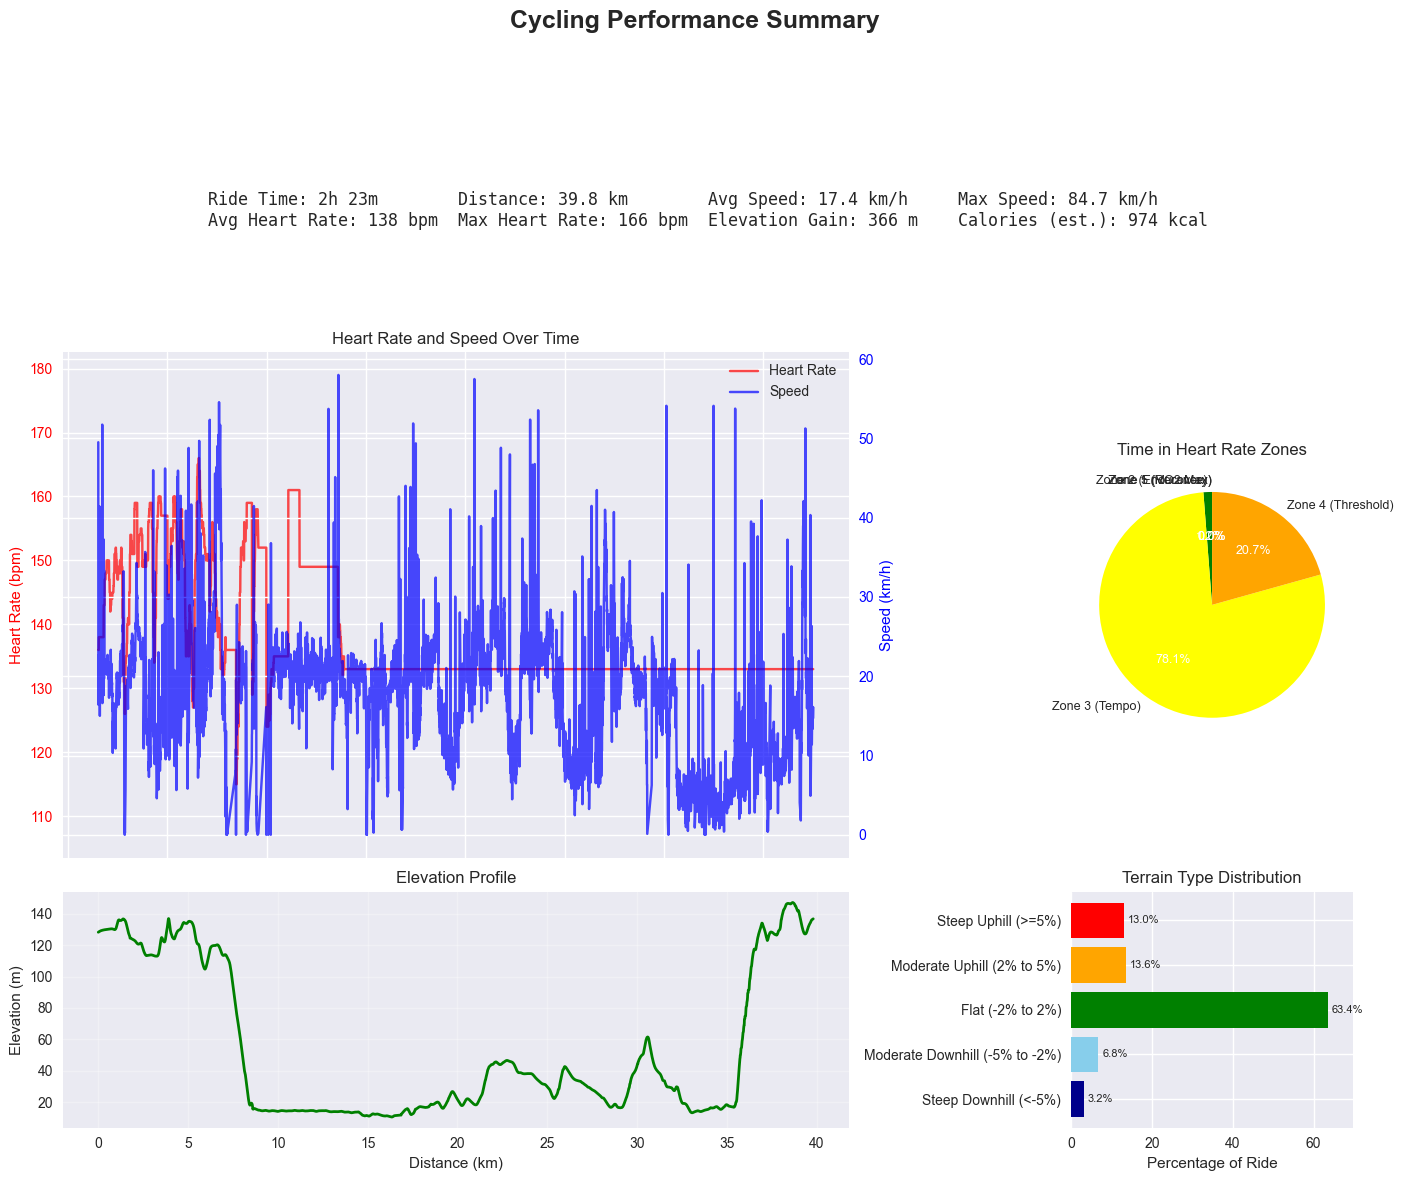

CYCLING PERFORMANCE SUMMARY
Date and Time: 2024-12-01 18:05 to 20:29
Duration: 2:23:57
------------------------------------------------------------
DISTANCE & SPEED
Total Distance: 39.81 km
Average Speed: 17.42 km/h
Maximum Speed: 84.68 km/h
------------------------------------------------------------
ELEVATION
Elevation Range: 10.5 m - 147.2 m (136.8 m difference)
Total Climbing: 365.5 m
Climbing Rate: 9.2 m/km
------------------------------------------------------------
HEART RATE
Average Heart Rate: 138 bpm
Maximum Heart Rate: 166 bpm
Heart Rate Zones:
  Zone 1 (Recovery): 0.0%
  Zone 2 (Endurance): 1.2%
  Zone 3 (Tempo): 78.1%
  Zone 4 (Threshold): 20.7%
  Zone 5 (VO2 Max): 0.0%
------------------------------------------------------------
ENERGY (ESTIMATED)
Total Energy: 974 kcal
Energy Rate: 24 kcal/km


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from datetime import timedelta

# Create a comprehensive performance summary dashboard
fig = plt.figure(figsize=(14, 12))

# Use GridSpec to create a complex layout
gs = GridSpec(4, 6, figure=fig)

# Create title for the dashboard
fig.suptitle("Cycling Performance Summary", fontsize=18, fontweight="bold", y=0.98)

# 1. Key Metrics Summary (top row spanning all columns)
ax1 = fig.add_subplot(gs[0, :])
ax1.axis("off")  # Turn off axis

# Calculate ride time
ride_start = df["time"].min()
ride_end = df["time"].max()
ride_duration = ride_end - ride_start
ride_hours = ride_duration.total_seconds() / 3600

# Get distance from previous calculation
total_distance = total_distance_km  # From the elevation analysis

# Calculate calories (rough estimate based on average power)
# Assuming average power output (rough estimate based on HR)
weight_kg = 75  # Default weight, adjust as needed
avg_hr = df["heart_rate"].mean()
estimated_avg_power = (avg_hr - 100) * 3  # Very rough approximation
calories_burned = estimated_avg_power * ride_hours * 3.6  # kJ to kcal

# Calculate metrics for summary
summary_metrics = {
    "Ride Time": f"{int(ride_hours)}h {int((ride_hours % 1) * 60):02d}m",
    "Distance": f"{total_distance:.1f} km",
    "Avg Speed": f"{avg_speed:.1f} km/h",
    "Max Speed": f"{max_speed:.1f} km/h",
    "Avg Heart Rate": f"{avg_hr:.0f} bpm",
    "Max Heart Rate": f"{max_hr:.0f} bpm",
    "Elevation Gain": f"{total_gain:.0f} m",
    "Calories (est.)": f"{calories_burned:.0f} kcal",
}

# Create a table of key metrics
metric_text = ""
cols = 4
rows = len(summary_metrics) // cols
for i, (metric, value) in enumerate(summary_metrics.items()):
    if i % cols == 0:
        metric_text += "\n"
    metric_text += f"{metric}: {value}".ljust(25)

ax1.text(
    0.5, 0.5, metric_text, fontsize=12, ha="center", va="center", fontfamily="monospace"
)

# 2. Heart Rate and Speed Combined Plot (middle row, spanning left 4 columns)
ax2 = fig.add_subplot(gs[1:3, :4])

# Convert datetime to numbers for plotting
time_num = mdates.date2num(np.array(df["time"].dt.to_pydatetime()))

# Create twin axes for speed and heart rate
ax2_twin = ax2.twinx()

# Plot heart rate
line1 = ax2.plot(time_num, df["heart_rate"], color="red", alpha=0.7, label="Heart Rate")
ax2.set_ylabel("Heart Rate (bpm)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(min(df["heart_rate"]) * 0.9, max(df["heart_rate"]) * 1.1)

# Plot speed on twin axis - use a separate approach to avoid dimension mismatch
# Resample the data to ensure consistent time series
speed_df = df_speed[["time", "speed_kph"]].copy()
speed_df = speed_df[speed_df["speed_kph"] < 60]  # Filter out unreasonably high speeds

# Create plot directly from the speed dataframe
line2 = ax2_twin.plot(
    mdates.date2num(np.array(speed_df["time"].dt.to_pydatetime())),
    speed_df["speed_kph"],
    color="blue",
    alpha=0.7,
    label="Speed",
)
ax2_twin.set_ylabel("Speed (km/h)", color="blue")
ax2_twin.tick_params(axis="y", labelcolor="blue")

# Format x-axis with dates
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=20))
ax2.set_xlabel("Time")
fig.autofmt_xdate()  # Rotation

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc="upper right")

# Add title
ax2.set_title("Heart Rate and Speed Over Time")

# 3. Elevation Profile (bottom row, spanning left 4 columns)
ax3 = fig.add_subplot(gs[3, :4])
ax3.plot(
    df_sorted["cumulative_dist_km"],
    df_sorted["elevation_smooth"],
    color="green",
    linewidth=2,
)
ax3.set_title("Elevation Profile")
ax3.set_xlabel("Distance (km)")
ax3.set_ylabel("Elevation (m)")
ax3.grid(True, alpha=0.3)

# 4. Heart Rate Zone Pie Chart (middle row, rightmost 2 columns)
ax4 = fig.add_subplot(gs[1:3, 4:])
# Use previously calculated heart rate zones
zone_names = list(zone_percentages.keys())
zone_values = list(zone_percentages.values())

# Define colors for zones
zone_colors = ["blue", "green", "yellow", "orange", "red"]

# Create pie chart
wedges, texts, autotexts = ax4.pie(
    zone_values, labels=zone_names, autopct="%1.1f%%", startangle=90, colors=zone_colors
)

# Styling for pie chart text
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_color("white")

ax4.set_title("Time in Heart Rate Zones")

# 5. Gradient Distribution (bottom row, rightmost 2 columns)
ax5 = fig.add_subplot(gs[3, 4:])
# Create gradient categories
gradient_categories = {
    "Steep Downhill (<-5%)": len(df_sorted[df_sorted["gradient"] < -5]),
    "Moderate Downhill (-5% to -2%)": len(
        df_sorted[(df_sorted["gradient"] >= -5) & (df_sorted["gradient"] < -2)]
    ),
    "Flat (-2% to 2%)": len(
        df_sorted[(df_sorted["gradient"] >= -2) & (df_sorted["gradient"] < 2)]
    ),
    "Moderate Uphill (2% to 5%)": len(
        df_sorted[(df_sorted["gradient"] >= 2) & (df_sorted["gradient"] < 5)]
    ),
    "Steep Uphill (>=5%)": len(df_sorted[df_sorted["gradient"] >= 5]),
}

# Calculate percentages
total = sum(gradient_categories.values())
gradient_pcts = {k: (v / total) * 100 for k, v in gradient_categories.items()}

# Plot horizontal bar chart
labels = list(gradient_pcts.keys())
values = list(gradient_pcts.values())
colors = ["darkblue", "skyblue", "green", "orange", "red"]
bars = ax5.barh(labels, values, color=colors)

# Add percentage labels to bars
for bar in bars:
    width = bar.get_width()
    ax5.text(
        width + 1,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}%",
        va="center",
        fontsize=8,
    )

ax5.set_xlim(0, max(values) * 1.1)
ax5.set_title("Terrain Type Distribution")
ax5.set_xlabel("Percentage of Ride")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Print comprehensive summary
print("=" * 60)
print("CYCLING PERFORMANCE SUMMARY")
print("=" * 60)
print(
    f"Date and Time: {ride_start.strftime('%Y-%m-%d %H:%M')} to {ride_end.strftime('%H:%M')}"
)
print(f"Duration: {str(timedelta(seconds=int(ride_duration.total_seconds())))}")
print("-" * 60)
print("DISTANCE & SPEED")
print(f"Total Distance: {total_distance:.2f} km")
print(f"Average Speed: {avg_speed:.2f} km/h")
print(f"Maximum Speed: {max_speed:.2f} km/h")
print("-" * 60)
print("ELEVATION")
print(
    f"Elevation Range: {min_elev:.1f} m - {max_elev:.1f} m ({max_elev - min_elev:.1f} m difference)"
)
print(f"Total Climbing: {total_gain:.1f} m")
print(f"Climbing Rate: {total_gain / total_distance:.1f} m/km")
print("-" * 60)
print("HEART RATE")
print(f"Average Heart Rate: {avg_hr:.0f} bpm")
print(f"Maximum Heart Rate: {max_hr:.0f} bpm")
print("Heart Rate Zones:")
for zone, percentage in zone_percentages.items():
    print(f"  {zone}: {percentage:.1f}%")
print("-" * 60)
print("ENERGY (ESTIMATED)")
print(f"Total Energy: {calories_burned:.0f} kcal")
print(f"Energy Rate: {calories_burned / total_distance:.0f} kcal/km")
print("=" * 60)

## 9. Conclusion and Insights

This analysis has provided comprehensive insights into the cycling performance based on GPX data. The key findings include:

-   **Distance and Duration**: The ride covered 39.8 km over 2 hours and 24 minutes, with an average speed of 17.4 km/h.
-   **Heart Rate Analysis**: The average heart rate was 138 bpm with a maximum of 166 bpm. The majority of the ride (78.1%) was spent in Zone 3 (Tempo) intensity, indicating a moderate to hard effort.

-   **Elevation Profile**: The route had a significant elevation range of 136.8 meters, with 365.5 meters of total climbing at a rate of 9.2 m/km. The terrain was predominantly flat (63.4%), with some moderate uphill (13.6%) and steep uphill (13.0%) sections.

-   **Speed Analysis**: The maximum speed reached was 84.7 km/h, likely during descents. The speed distribution shows most of the ride was performed at 15-25 km/h.

-   **Energy Expenditure**: The estimated caloric expenditure was 974 kcal, at a rate of 24 kcal/km.

This notebook demonstrates how to extract valuable performance metrics and visualizations from raw GPX data, which can help cyclists track their progress, understand their effort distribution, and analyze their route characteristics.
